In [1]:
# https://github.com/cstorm125/sophia
# https://cs231n.github.io/neural-networks-case-study/
# http://cs231n.stanford.edu/slides/2023/lecture_4.pdf -- for scalar and vector gradient
# https://www.haio.ir/app/uploads/2021/12/Neural-Networks-from-Scratch-in-Python-by-Harrison-Kinsley-Daniel-Kukiela-z-lib.org_.pdf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Module

In [3]:
class Module:
    def __init__(self):
        pass

# SIgmoid

In [4]:
x = np.arange(-10, 10.2, 0.2)

def plot_act(x, y):
    plt.figure(figsize=(5,3))
    plt.plot(x, y)
    plt.grid()

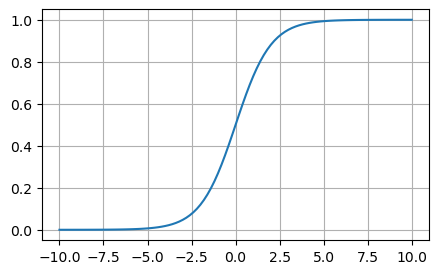

In [5]:
class Sigmoid(Module):
    def __call__(self, x):
        out = 1/(1+np.exp(-x))
        return out
    
sig = Sigmoid()
y = sig(x)
plot_act(x, y)

# Tanh

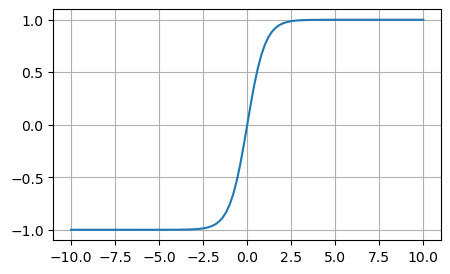

In [6]:
class Tanh(Module):
    def __call__(self, x):
        out = np.tanh(x)
        return out

tanh = Tanh()
y = tanh(x)
plot_act(x, y)

# ReLU

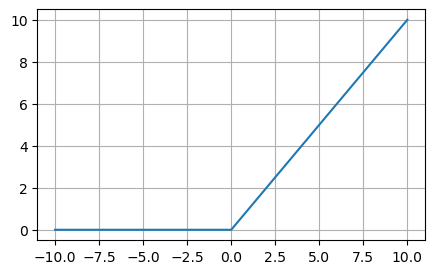

In [7]:
class ReLU(Module):
    def __init__(self):
        self._backward = lambda: None
        
    def __call__(self, x):
        out = np.maximum(0, x)
        def _backward(up_grad):
            grad = (out > 0).astype(np.float64) * up_grad
            return grad
        self._backward = _backward
        return out

relu = ReLU()
y = relu(x)
plot_act(x, y)

# LeakyReLU

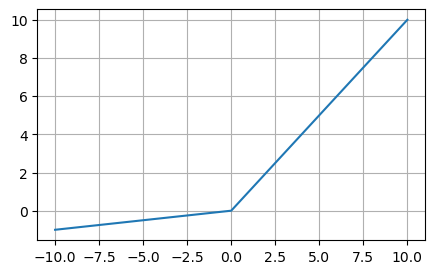

In [8]:
class LeakyReLU(Module):
    def __call__(self, x):
        out = np.maximum(0.1*x, x)
        return out

leak_relu = LeakyReLU()
y = leak_relu(x)
plot_act(x, y)

# Softmax

In [9]:
class Softmax(Module):
    def __inti__(self):
        self._backward = lambda: None
    
    def __call__(self, z):
        exp_z = np.exp(z)
        s = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        def _backward(up_grad):
            grad = None
            return grad
        self._backward = _backward
        return s

# Linear Function

In [10]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = None
        self.bias = None
        self._backward = lambda: None 
        
        self.init_parameters()
        
    def init_parameters(self):
        # follow Xavier Initialization
        self.weight = np.random.randn(self.in_features, self.out_features)/np.sqrt(self.in_features)
        self.bias = np.random.randn(1, self.out_features)/np.sqrt(self.out_features)
        
    def __call__(self, X):
        out = X.dot(self.weight) + self.bias
        def _backward(up_grad):
            X_grad = up_grad.dot(self.weight.T)
            w_grad = X.T.dot(up_grad)
            b_grad = np.sum(up_grad, axis=0, keepdims=True)
            return X_grad, w_grad, b_grad
        self._backward = _backward
        return out
        

# Softmax classifier loss function

In [11]:
# Softmax classifier loss with logit, cross-entropy loss
class SoftmaxLoss(Module):
    def __init__(self):
        self._backward = lambda : None
        
    def __call__(self, input, target):
        n = len(input)
        loss = np.average(-np.log(input[range(n), target]))
        def _backward(up_grad):
            input_grad = input*up_grad
            input_grad[range(n), target] -= 1
            input_grad /= n
            return input_grad
        self._backward = _backward
        return loss

# Regularization

In [12]:
# fixed this <------------------------------------------------------
class WeightDecay:
    def __init__(self):
        self._backward = lambda : None
        
    def __call__(self, w, reg=1e-3):
        loss = 0
        for i in range(len(w)):
            loss += 0.5*reg*np.sum(w[i]*w[i])
        def _backward():
            grad = [reg*w[i] for i in range(len(w))]  
            return grad
        self._backward = _backward
        return loss

# Training a softmax linear classifier

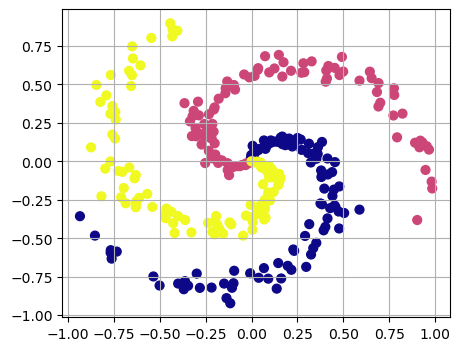

In [13]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
total_n = N*K
X = np.zeros((total_n,D)) 
y = np.zeros(total_n, dtype='uint8') 
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) 
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    
plt.figure(figsize=(5,4))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='plasma')
plt.grid()

In [14]:
np.random.seed(42)

epochs = 15000
reg = 1e-3
lr = 5e-2
h = 100

L1 = Linear(D, h)
relu = ReLU()
L2 = Linear(h, K)
softmax = Softmax()
loss_fn = SoftmaxLoss()

In [15]:
y_loss = []
x_epoch = []

for epoch in range(epochs+1):
    # forward pass
    h1 = relu(L1(X))
    logit = L2(h1)
    pred_probs = softmax(logit)
    loss = loss_fn(pred_probs, y) 
    if epoch % 1000 == 0:
        x_epoch.append(epoch)
        y_loss.append(loss)
        print(f"loss {epoch}: {loss:.4f}")

    # backward pass
    up_grad = np.ones_like(pred_probs)
    up_grad = loss_fn._backward(up_grad) # softmax classifier loss - don't have to find softmax grad
    up_grad, w2_grad, b2_grad = L2._backward(up_grad)
    up_grad = relu._backward(up_grad)
    up_grad, w1_grad, b1_grad = L1._backward(up_grad)

    # update step
    L2.weight += -lr*w2_grad 
    L2.bias += -lr*b2_grad
    L1.weight += -lr*w1_grad 
    L1.bias += -lr*b1_grad

loss 0: 1.2199
loss 1000: 0.4258
loss 2000: 0.2679
loss 3000: 0.1995
loss 4000: 0.1605
loss 5000: 0.1351
loss 6000: 0.1175
loss 7000: 0.1046
loss 8000: 0.0947
loss 9000: 0.0869
loss 10000: 0.0805
loss 11000: 0.0753
loss 12000: 0.0709
loss 13000: 0.0671
loss 14000: 0.0639
loss 15000: 0.0610


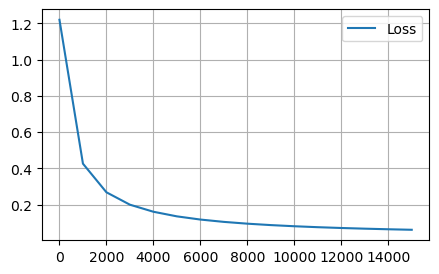

In [16]:
plt.figure(figsize=(5,3))
plt.plot(x_epoch, y_loss); 
plt.legend(['Loss'])
plt.grid();

In [18]:
def predict(X):
    h1 = relu(L1(X))
    logit = L2(h1)
    pred_probs = softmax(logit)
    pred_classes = np.argmax(pred_probs, axis=1)
    return pred_classes

In [20]:
y_pred = predict(X)
y_pred, y

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

# Decision boundaries

In [89]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(func, X, y):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    padding = 0.5
    x_min, x_max = X[:, 0].min()-padding, X[:, 0].max()+padding
    y_min, y_max = X[:, 1].min()-padding, X[:, 1].max()+padding
    
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    spatial_X = np.c_[xx.ravel(), yy.ravel()]
    
    y_pred = predict(spatial_X)
    y_pred = y_pred.reshape(xx.shape)
    
    plt.contourf(xx, yy, y_pred, cmap=cmap_light, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=cmap_bold)

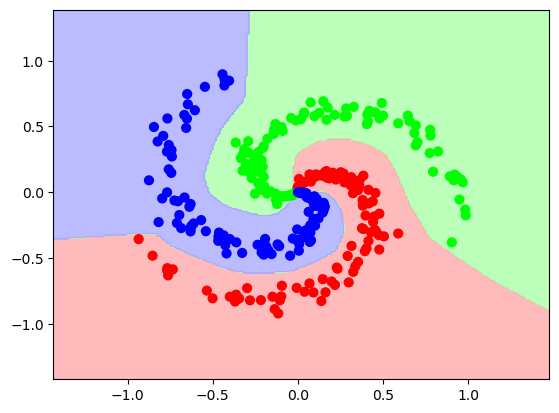

In [90]:
plot_decision_boundary(predict, X, y)